In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8,5)

# create output directory if not exists
os.makedirs("outputs", exist_ok=True)

### Load Data

In [2]:
sentiment_df = pd.read_csv("/content/fear_greed_index.csv")
trades_df = pd.read_csv("/content/historical_data - historical_data.csv")

In [3]:
sentiment_df.head()

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [4]:
trades_df.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


### Clean and Time Alignment

In [6]:
# Convert sentiment dates
sentiment_df["Date"] = pd.to_datetime(sentiment_df["date"], errors="coerce")

# Convert trade timestamps (day-first + mixed formats)
trades_df["Timestamp"] = pd.to_datetime(
    trades_df["Timestamp IST"],
    dayfirst=True,
    format="mixed",
    errors="coerce"
)

# Drop rows where timestamp conversion failed
trades_df = trades_df.dropna(subset=["Timestamp"])

# Align by date
trades_df["Date"] = trades_df["Timestamp"].dt.date
sentiment_df["Date"] = sentiment_df["Date"].dt.date

# Merge datasets
df = trades_df.merge(
    sentiment_df[["Date", "classification", "value"]],
    on="Date",
    how="inner"
)

### Feature Engineering

In [7]:
# Exposure proxy (risk)
df["exposure_usd"] = df["Size USD"]

# Signed PnL (profitability)
df["closed_pnl"] = df["Closed PnL"]

# Trade count proxy
df["trade_count"] = 1

# Aggregate daily metrics by sentiment
daily_metrics = df.groupby(["Date", "classification"]).agg({
    "exposure_usd": "sum",
    "closed_pnl": "sum",
    "trade_count": "sum"
}).reset_index()

### Risk-Adjusted Performance (Sharpe Ratio)

In [8]:
# Daily returns proxy
daily_metrics["daily_return"] = daily_metrics["closed_pnl"] / (
    daily_metrics["exposure_usd"].replace(0, np.nan)
)

sharpe_df = daily_metrics.groupby("classification")["daily_return"].agg(
    mean_return="mean",
    std_return="std"
).reset_index()

sharpe_df["sharpe"] = sharpe_df["mean_return"] / sharpe_df["std_return"]

### Exposure vs Sentiment

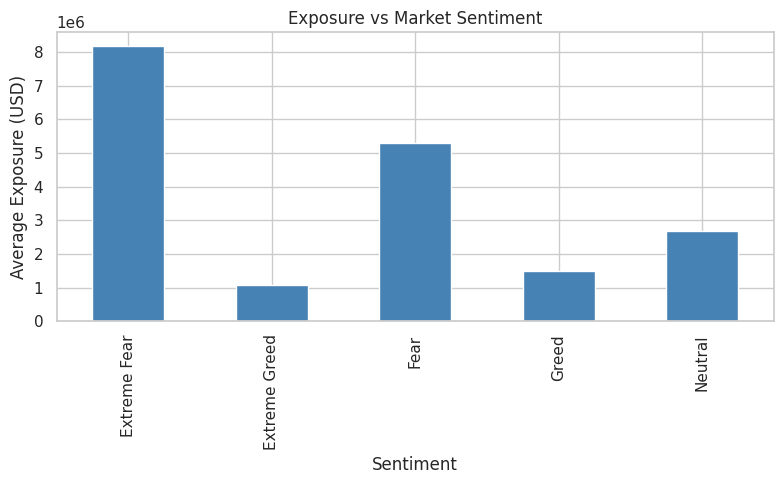

In [9]:
exposure_plot = daily_metrics.groupby("classification")["exposure_usd"].mean()

exposure_plot.plot(kind="bar", color="steelblue")
plt.title("Exposure vs Market Sentiment")
plt.ylabel("Average Exposure (USD)")
plt.xlabel("Sentiment")
plt.tight_layout()
plt.savefig("outputs/exposure_vs_sentiment.png")
plt.show()

### Sharpe Ratio vs Sentiment

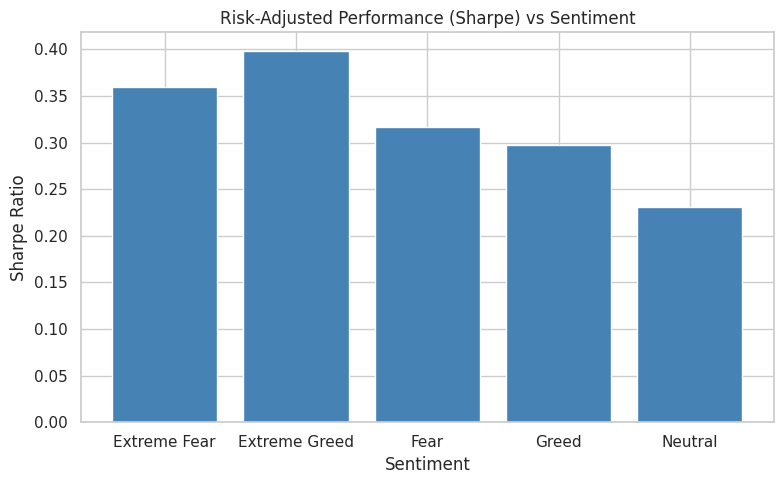

In [12]:
plt.bar(sharpe_df["classification"], sharpe_df["sharpe"], color="steelblue")
plt.title("Risk-Adjusted Performance (Sharpe) vs Sentiment")
plt.ylabel("Sharpe Ratio")
plt.xlabel("Sentiment")
plt.tight_layout()
plt.savefig("outputs/sharpe_vs_sentiment.png")
plt.show()

### Trade Count vs Sentiment

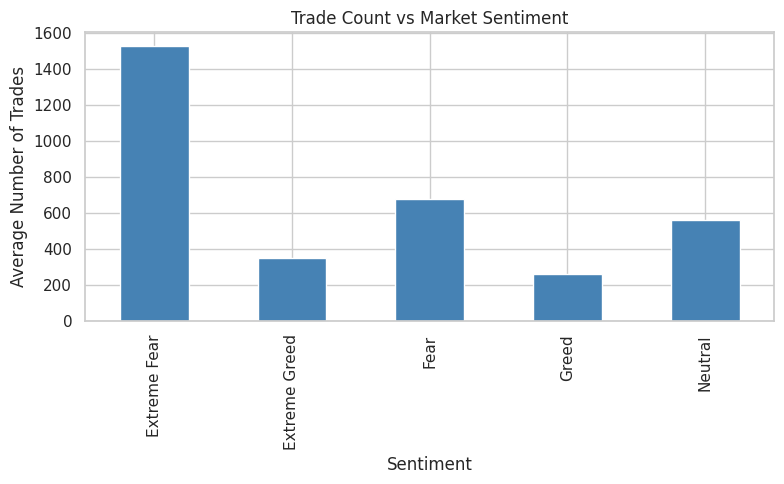

In [13]:
trade_plot = daily_metrics.groupby("classification")["trade_count"].mean()

trade_plot.plot(kind="bar", color="steelblue")
plt.title("Trade Count vs Market Sentiment")
plt.ylabel("Average Number of Trades")
plt.xlabel("Sentiment")
plt.tight_layout()
plt.savefig("outputs/trade_count_vs_sentiment.png")
plt.show()